In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Bidirectional
from keras.optimizers import Adam
from numpy.random import seed
from utils import *

In [4]:
seed(1)
tf.random.set_seed(1)

In [62]:
n_timesteps = 10
n_epochs = 50
model_type = 'Bidirectional_lstm'

In [8]:
core_data = pd.read_csv('601988.SH.csv')
core_data.index = pd.to_datetime(core_data['trade_date'], format='%Y%m%d')
core_data = core_data.loc[:, ['open', 'high', 'low', 'close', 'amount']]
core_data

,open,high,low,close,amount
trade_date,,,,,
2007-01-04,5.69,5.97,5.37,5.63,4224852.614
2007-01-05,5.30,5.34,5.07,5.07,4050377.943
2007-01-08,4.87,5.14,4.83,5.08,2763751.983
2007-01-09,5.06,5.19,4.95,5.18,2198327.249
2007-01-10,5.25,5.29,5.05,5.10,1915221.182
...,...,...,...,...,...
2022-03-11,3.08,3.11,3.06,3.10,550569.534
2022-03-14,3.08,3.12,3.07,3.09,489277.432
2022-03-15,3.09,3.09,3.02,3.03,886628.898


In [17]:
arima_residuals_data = pd.read_csv('ARIMA_residuals1.csv')
arima_residuals_data.index = pd.to_datetime(arima_residuals_data['trade_date'])
arima_residuals_data = arima_residuals_data.drop('trade_date', axis=1)
arima_residuals_data

,0
trade_date,
2007-01-05,-0.559316
2007-01-08,-0.007379
2007-01-09,0.057436
2007-01-10,-0.074978
2007-01-11,-0.164225
...,...
2022-03-11,0.019201
2022-03-14,-0.008543
2022-03-15,-0.058028


In [18]:
arima_data = pd.read_csv('ARIMA.csv')
arima_data

,trade_date,close
0,2021-06-22,3.070427
1,2021-06-23,3.068420
2,2021-06-24,3.069204
3,2021-06-25,3.069204
4,2021-06-28,3.088522
...,...,...
175,2022-03-11,3.080804
176,2022-03-14,3.098557
177,2022-03-15,3.088036
178,2022-03-16,3.032092


In [101]:
idx = 3500
training_set = arima_residuals_data.iloc[1:idx, :]
test_set = arima_residuals_data.iloc[idx:, :]

core_training_set = core_data.iloc[1:idx, :]
core_test_set = core_data.iloc[idx:, :]
core_test_set

,open,high,low,close,amount
trade_date,,,,,
2021-06-21,3.06,3.08,3.06,3.07,359751.317
2021-06-22,3.07,3.08,3.06,3.07,285873.151
2021-06-23,3.07,3.08,3.06,3.07,268733.070
2021-06-24,3.07,3.08,3.06,3.07,252945.198
2021-06-25,3.08,3.10,3.07,3.09,390793.156
...,...,...,...,...,...
2022-03-11,3.08,3.11,3.06,3.10,550569.534
2022-03-14,3.08,3.12,3.07,3.09,489277.432
2022-03-15,3.09,3.09,3.02,3.03,886628.898


In [102]:
scaler = MinMaxScaler(feature_range=(0,1))
core_scaler = MinMaxScaler(feature_range=(0,1))

training_set_scaled = scaler.fit_transform(training_set)
test_set_scaled = scaler.fit_transform(test_set)

core_training_set_scaled = core_scaler.fit_transform(core_training_set)
core_test_set_scaled = core_scaler.fit_transform(core_test_set)
training_set_scaled

array([[0.51824048],
       [0.58001731],
       [0.45381007],
       ...,
       [0.51638778],
       [0.50809105],
       [0.53412306]])

In [103]:
core_training_set_scaled

array([[0.57489879, 0.5625    , 0.54906054, 0.52087475, 0.14698473],
       [0.48785425, 0.5234375 , 0.49895616, 0.52286282, 0.10011205],
       [0.52631579, 0.53320312, 0.52400835, 0.54274354, 0.07951324],
       ...,
       [0.12348178, 0.125     , 0.13152401, 0.12723658, 0.01969927],
       [0.12550607, 0.125     , 0.13361169, 0.12524851, 0.01416377],
       [0.12550607, 0.12304688, 0.12943633, 0.12127237, 0.0177832 ]])

In [104]:
print(core_training_set_scaled.shape)
print(training_set_scaled.shape)

(3499, 5)
(3499, 1)


In [105]:
### TODO: Redefine Data Split function in ur own way
X_train, y_train = data_split(training_set_scaled, n_timesteps)
X_train_new = X_train
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
if np.array_equal(X_train, X_train_new):
    print("Same As Before Reshaping")

X_test, y_test = data_split(test_set_scaled, n_timesteps)
X_test_new = X_test
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
if np.array_equal(X_test, X_test_new):
    print("Same As Before Reshaping")

Same As Before Reshaping
Same As Before Reshaping


In [106]:
core_X_train, core_y_train = data_split(core_training_set_scaled, n_timesteps)
core_X_train_new = core_X_train
core_X_train = core_X_train.reshape(core_X_train.shape[0], core_X_train.shape[1], 5)
if np.array_equal(core_X_train, core_X_train_new):
    print("Same As Before Reshaping")
    
core_X_test, core_y_test = data_split(core_test_set_scaled, n_timesteps)
core_X_test_new = core_X_test
core_X_test = core_X_test.reshape(core_X_test.shape[0], core_X_test.shape[1], 5)
if np.array_equal(core_X_test, core_X_test_new):
    print("Same As Before Reshaping")

Same As Before Reshaping
Same As Before Reshaping


In [107]:
def lstm(model_type, X_train, core_X_train):
    # Core LSTM Model
    if model_type=='lstm':
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))
        
        core_model = Sequential()
        core_model.add(LSTM(units=50, activation='relu', input_shape=(core_X_train.shape[1],5)))
        core_model.add(Dense(units=5))
    
    elif model_type=='Bilayer_lstm':
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(units=1))
        
        core_model = Sequential()
        core_model.add(LSTM(units=50, activation='relu', input_shape=(core_X_train.shape[1],5)))
        core_model.add(LSTM(units=50, activation='relu'))
        core_model.add(Dense(units=5))
    
    elif model_type == 'Bidirectional_lstm':
        model = Sequential()
        model.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))
        
        core_model = Sequential()
        core_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(core_X_train.shape[1],5)))
        core_model.add(Dense(units=5))
        
    return model, core_model

In [108]:
model, core_model = lstm(model_type, X_train, core_X_train)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
adam = Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mse')
core_model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, batch_size=32, epochs=n_epochs, validation_data=(X_test, y_test), validation_freq=1)
core_history = core_model.fit(core_X_train, core_y_train, batch_size=32, epochs=n_epochs, validation_data=(core_X_test, core_y_test), validation_freq=1)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
110/110 [==============================] - ETA: 0s - loss: 0.0172WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000017C49BFC708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
110/110 [==============================] - 6s 17ms/step - loss: 0.0065 - val_loss: 0.0171
Epoch 2/50
110/110 [==============================] - 1s 11ms/step - loss: 8.0928e-04 - val_loss: 0.0160
Epoch 3/50
110/110 [==============================] - 1s 11ms/step - loss: 6.8122e-04 - val_loss: 0.0150
Epoch 4/50
110/110 [==============================] - 1s 11ms/step - loss: 6.3186e-04 - val_loss: 0.0142
Epoch 5/50
110/110 [==============================] - 1s 10ms/step - loss: 5.9049e-04 - val_loss: 0.0132
Epoch 6/50
110/110 [==============================] - 1s 10ms/step - loss: 5.3711e-04 - val_loss: 0.0133
Epoch 7/50
110/110 [==============================] - 1s 11ms/step - loss:

In [110]:
type(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 110}
dict_keys(['loss', 'val_loss'])


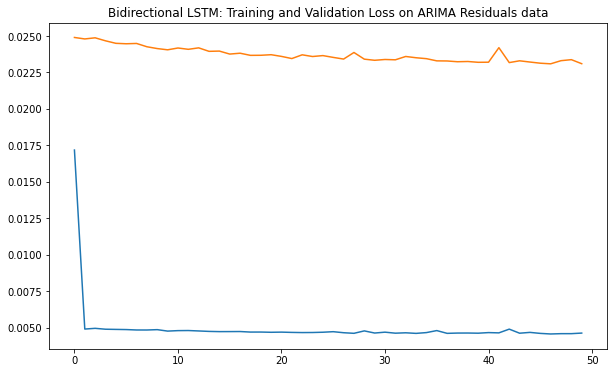

In [111]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Bidirectional LSTM: Training and Validation Loss on ARIMA Residuals data")
plt.show()

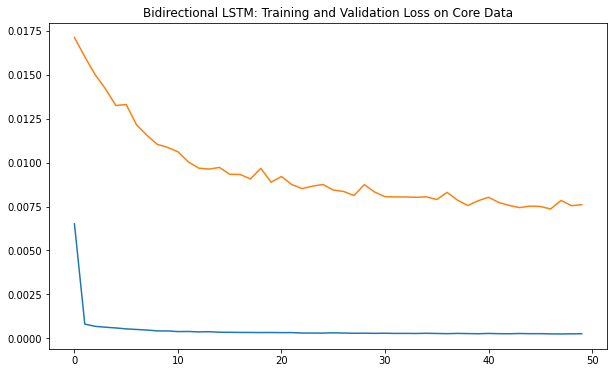

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(core_history.history['loss'], label='Training Loss')
plt.plot(core_history.history['val_loss'], label='Validation Loss')
plt.title("Bidirectional LSTM: Training and Validation Loss on Core Data")
plt.show()

In [132]:
core_predicted_stock_price = core_model.predict(core_X_test)
core_predicted_stock_price = core_scaler.inverse_transform(core_predicted_stock_price)
core_predicted_stock_price_close = np.array(core_predicted_stock_price[:, 3]).flatten().tolist()
# core_predicted_stock_price_close

6/6 [==============================] - 0s 5ms/step


In [133]:
core_predicted_stock_price_dict = {
    'trade_date': core_data.index[idx+10:],
    'close': core_predicted_stock_price_close
}
core_predicted = pd.DataFrame(core_predicted_stock_price_dict)
core_predicted = core_predicted.set_index('trade_date', drop=True)
# core_predicted = core_predicted.drop(['trade_date'])
core_predicted

,close
trade_date,
2021-07-05,3.083383
2021-07-06,3.079980
2021-07-07,3.088020
2021-07-08,3.080873
2021-07-09,3.072390
...,...
2022-03-11,3.091879
2022-03-14,3.094396
2022-03-15,3.096405


In [134]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price_close = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price_dict = {
    'trade_date': arima_residuals_data.index[idx+10:],
    'close': predicted_stock_price_close
}
predicted = pd.DataFrame(core_predicted_stock_price_dict)
predicted = predicted.set_index(['trade_date'], drop=True)
predicted

6/6 [==============================] - 0s 5ms/step


,close
trade_date,
2021-07-05,3.083383
2021-07-06,3.079980
2021-07-07,3.088020
2021-07-08,3.080873
2021-07-09,3.072390
...,...
2022-03-11,3.091879
2022-03-14,3.094396
2022-03-15,3.096405


In [135]:
core_real_price = core_scaler.inverse_transform(core_y_test)
core_real_price_list = np.array(core_real_price[:, 3]).flatten().tolist()
core_real_price_dict = {
    'trade_date': core_data.index[idx+10:],
    'close': core_real_price_list
}
core_real = pd.DataFrame(core_real_price_dict)
core_real = core_real.set_index(['trade_date'], drop=True)
core_real

,close
trade_date,
2021-07-05,3.08
2021-07-06,3.09
2021-07-07,3.08
2021-07-08,3.07
2021-07-09,3.07
...,...
2022-03-11,3.10
2022-03-14,3.09
2022-03-15,3.03


In [136]:
real_price = scaler.inverse_transform(y_test)
real_price_list = np.array(real_price[:, 0]).flatten().tolist()
real_price_dict = {
    'trade_date': arima_residuals_data.index[idx+10:],
    'close': real_price_list
}
real = pd.DataFrame(real_price_dict)
real = real.set_index(['trade_date'], drop=True)
real

,close
trade_date,
2021-07-06,0.010761
2021-07-07,-0.008891
2021-07-08,-0.008807
2021-07-09,-0.000367
2021-07-12,-0.010019
...,...
2022-03-11,0.019201
2022-03-14,-0.008543
2022-03-15,-0.058028


In [137]:
finalpredicted_stock_price = pd.concat([arima_data, predicted]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date']) 
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

C:\Users\sawan\anaconda3\envs\lstm_x\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


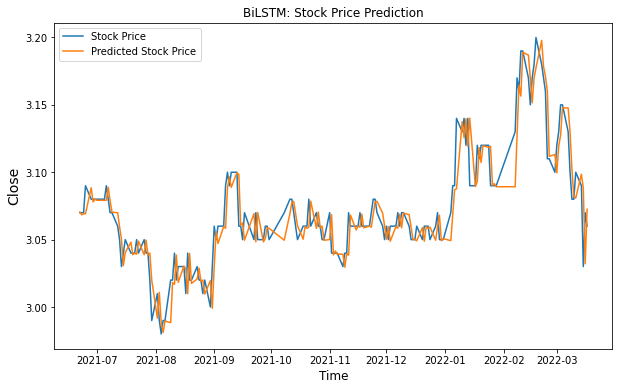

In [138]:
plt.figure(figsize=(10, 6))
plt.plot(core_data.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('Bidirectional LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [139]:
core_real

,close
trade_date,
2021-07-05,3.08
2021-07-06,3.09
2021-07-07,3.08
2021-07-08,3.07
2021-07-09,3.07
...,...
2022-03-11,3.10
2022-03-14,3.09
2022-03-15,3.03


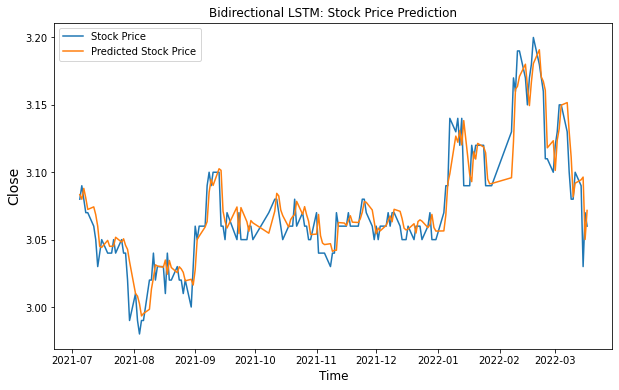

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(core_real['close'], label='Stock Price')
plt.plot(core_predicted['close'], label='Predicted Stock Price')
plt.title('Bidirectional LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [141]:
yhat = core_data.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'],yhat)

MSE: 0.00027
RMSE: 0.01652
MAE: 0.01201
R2: 0.84210


In [146]:
xyz = evaluation_metric(finalpredicted_stock_price['close'],yhat)

MSE: 0.00027
RMSE: 0.01652
MAE: 0.01201
R2: 0.84210
